In [2]:
import sys
import os
import wandb
import torch
import numpy as np

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc

from ml_collections import ConfigDict

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from elliptic_files.train_elliptic import train_elliptic,generate_data,samples_param
from elliptic_files.FEM_Solver import FEMSolver
from elliptic_files.elliptic_mcmc import *
from elliptic_files.utilities import *
from Base.lla import dgala
from Base.utilities import histogram_,stat_ar

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tiaming Experiment

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

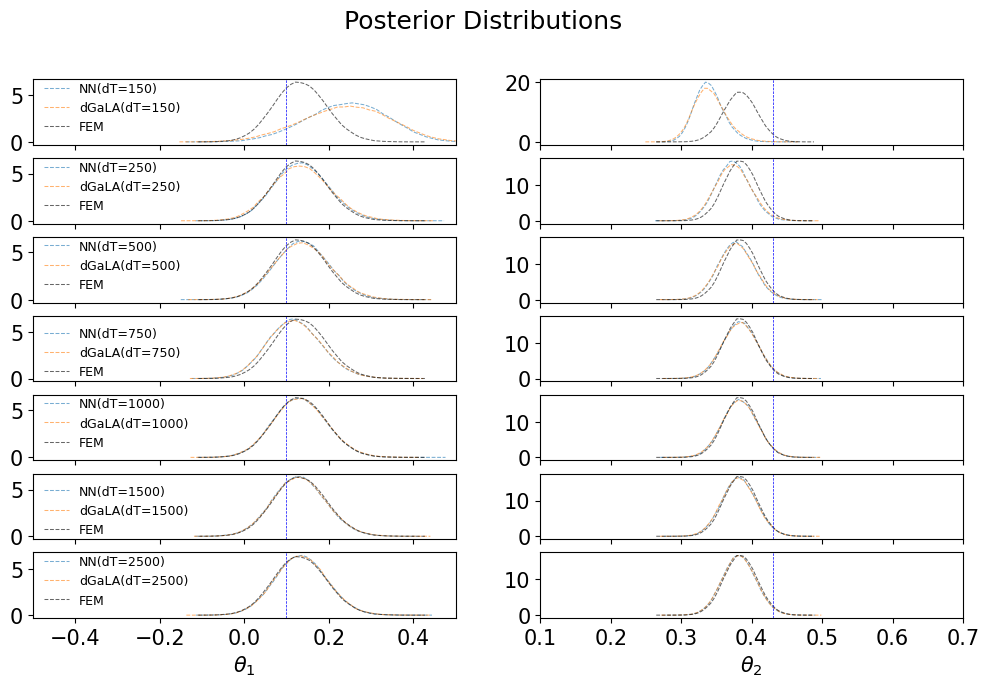

In [26]:
vr = 1e-4
theta_th=np.array([0.098, 0.430])
N = [150,250,500,750,1000,1500,2500]
bins = 50

fig, axs = plt.subplots(len(N), 2, figsize=(12, 7), sharex="col")
fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 15})

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/NN_ss{nobs}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./results/dgala_ss{nobs}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGaLA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGaLA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, prop={'size': 9})
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)


axs[-1,0].set_xlim((-0.5,0.5)),axs[-1,1].set_xlim((0.1,0.7))
axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

plt.savefig(f"./results/elliptic_pd_{vr}.pdf")

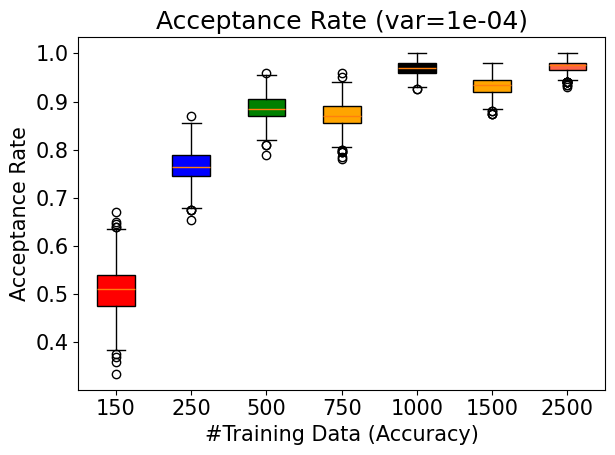

In [21]:
acceptance_mean_list = np.array([stat_ar(np.load(f"./results/mcmc_da_nn_{n}_{vr}.npy"),every=200)[-1] for n in N])
cl = ["red", "blue", "green", "orange", "black","orange","tomato"]

bplot = plt.boxplot(acceptance_mean_list.T,patch_artist=True, tick_labels=[str(n) for n in N])  # Transpose to plot along axis 1

# fill with colors
for patch, color in zip(bplot['boxes'], cl):
    patch.set_facecolor(color)

# Customize the plot
plt.title(f"Acceptance Rate (var={vr:.0e})")
plt.xlabel("#Training Data (Accuracy)")
plt.ylabel("Acceptance Rate")
#plt.ylim((0,0.5))
plt.tight_layout()
# Save the plotx
plt.savefig(f"./results/elliptic_da_ar_{vr}.pdf")
plt.legend(frameon =False)
plt.show()

(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

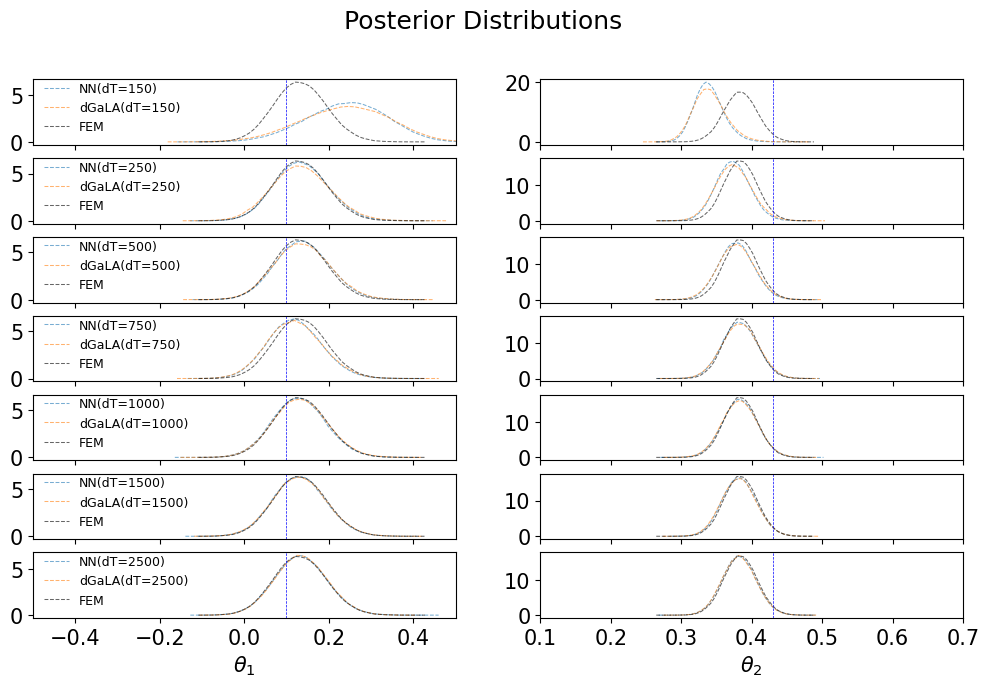

In [27]:
vr = 1e-4
theta_th=np.array([0.098, 0.430])
N = [150,250,500,750,1000,1500,2500]
bins = 50

fig, axs = plt.subplots(len(N), 2, figsize=(12, 7), sharex="col")
fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 15})

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/NN_s{nobs}_wd{1e-3}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./results/dgala_s{nobs}_wd{1e-3}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGaLA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGaLA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, prop={'size': 9})
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)


axs[-1,0].set_xlim((-0.5,0.5)),axs[-1,1].set_xlim((0.1,0.7))
axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

#plt.savefig(f"./results/elliptic_pd_{vr}.pdf")

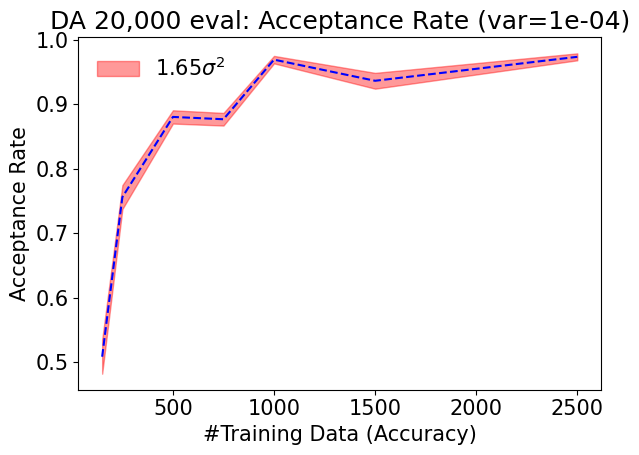

In [ ]:
acceptance_mean_list = [stat_ar(np.load(f"./results/mcmc_da_nn_{n}_{vr}.npy"),every=2000)[0] for n in N]
acceptance_std_list = [stat_ar(np.load(f"./results/mcmc_da_nn_{n}_{vr}.npy"),every=2000)[1] for n in N]

# Convert to numpy arrays for proper element-wise operations
acceptance_mean_array = np.array(acceptance_mean_list)
acceptance_std_array = np.array(acceptance_std_list)

# Compute upper and lower bounds for uncertainty region
upper = acceptance_mean_array + 1.645*acceptance_std_array
lower = acceptance_mean_array - 1.645*acceptance_std_array

# Plot uncertainty region
plt.fill_between(N, upper, lower, alpha=0.4, color="red", label=r"1.65$\sigma^2$")

# Plot mean acceptance rate
plt.plot(N, acceptance_mean_array, linestyle="--", color="blue")

# Titles and labels
plt.title(f"DA 20,000 eval: Acceptance Rate (var={vr:.0e})")
plt.xlabel("#Training Data (Accuracy)")
plt.ylabel("Acceptance Rate")
plt.tight_layout()
# Save the plot
plt.savefig(f"./results/elliptic_da_ar_{vr}.pdf")
plt.legend(frameon =False)
plt.show()

In [3]:
def histogram2D(x,y,bins=80):
    xbins = np.linspace(-1, 1, bins)  # 30 bins in X
    ybins = np.linspace(0.25, 0.5, bins)  # 30 bins in Y

    # Compute 2D histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=[xbins, ybins])

    # Create meshgrid for contour plot
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])  # Use bin edges
    return X,Y,H.T

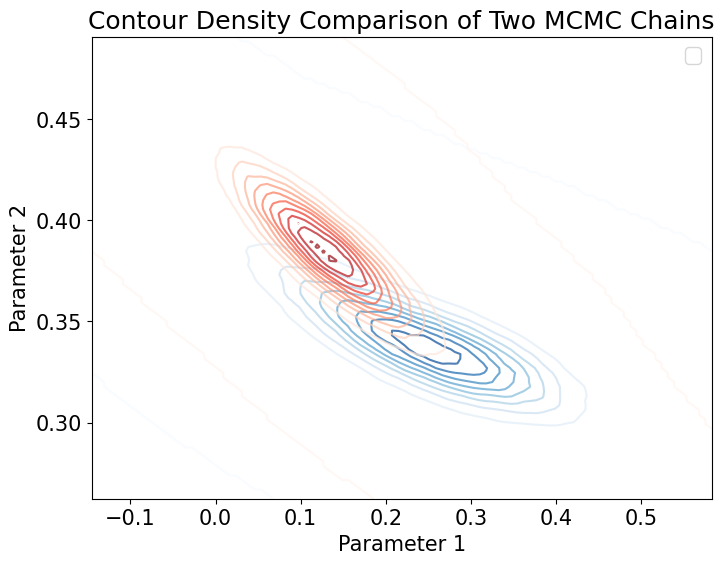

In [7]:
from scipy.stats import gaussian_kde

chain1 = np.load(f'./results/NN_ss{150}_var{vr}.npy')
chain2 = np.load(f'./results/FEM_var{vr}.npy')

# Create a grid for density estimation
xmin, xmax = min(chain1[:, 0].min(), chain2[:, 0].min()), max(chain1[:, 0].max(), chain2[:, 0].max())
ymin, ymax = min(chain1[:, 1].min(), chain2[:, 1].min()), max(chain1[:, 1].max(), chain2[:, 1].max())
X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))

# Estimate density for chain 1
kde1 = gaussian_kde(chain1.T)
Z1 = kde1(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# Estimate density for chain 2
kde2 = gaussian_kde(chain2.T)
Z2 = kde2(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plt.figure(figsize=(8, 6))

# Contour plots
plt.contour(X, Y, Z1, levels=10, cmap="Blues", alpha=0.7)
plt.contour(X, Y, Z2, levels=10, cmap="Reds", alpha=0.7)

plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Contour Density Comparison of Two MCMC Chains")
plt.legend(["Chain 1", "Chain 2"])
plt.show()


No handles with labels found to put in legend.


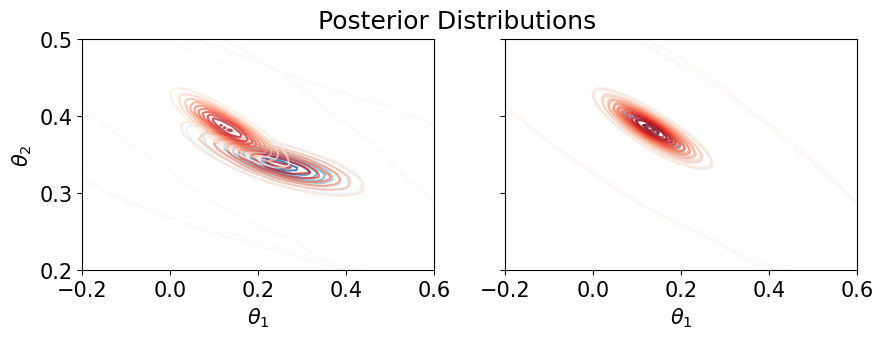

In [11]:
vr = 1e-4
theta_th=np.array([0.098, 0.430])
N = [150,2500]
bins = 50
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(1,len(N), figsize=(10, 3), sharey=True)
fig.suptitle(f"Posterior Distributions")
#fig.suptitle(f"Posterior Distributions: Var  = {vr}")
plt.rcParams.update({'font.size': 15})

for i,nobs in  enumerate(N):
    X, Y = np.meshgrid(np.linspace(-0.2, 0.6, 100), np.linspace(0.2, 0.5, 100))
    sample = np.load(f'./results/NN_ss{nobs}_var{vr}.npy')
    sample2 = np.load(f'./results/dgala_ss{nobs}_var{vr}.npy')
    sample3 = np.load(f'./results/FEM_var{vr}.npy')

    # Estimate density for chain 1
    kde1 = gaussian_kde(sample.T)
    Z1 = kde1(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Estimate density for chain 2
    kde2 = gaussian_kde(sample2.T)
    Z2 = kde2(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Estimate density for chain 2
    kde3 = gaussian_kde(sample3.T)
    Z3 = kde3(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    axs[i].contour(X, Y, Z1, levels=10, cmap="Blues", alpha=0.7, label = "NN")
    axs[i].contour(X, Y, Z2, levels=10, cmap="Reds", alpha=0.7, label = "dGaLA")
    axs[i].contour(X, Y, Z3, levels=10, cmap="Reds", alpha=0.7, label = "FEM")
       
    axs[i].set_xlabel(r"$\theta_1$")
axs[0].set_ylabel(r"$\theta_2$")
axs[0].legend(frameon = False)
plt.savefig(f"./results/elliptic_posterior_{vr}.pdf")

plt.show()

In [ ]:

def get_deepgalerkin_config():
    config = ConfigDict()

    # Weights & Biases
    config.wandb = wandb = ConfigDict()
    wandb.project = "Elliptic-training"
    wandb.name = "MDNN"
    wandb.tag = None

    # General settings
    config.nn_model = "MDNN"  # Options: "NN", "WRF", "MDNN"
    config.lambdas = {"elliptic":1, "ubcl":1, "ubcr":1}

    # Model-specific settings
    config.model = ConfigDict()
    config.model.input_dim = 3
    config.model.hidden_dim = 20
    config.model.num_layers = 2
    config.model.out_dim = 1
    config.model.activation = "tanh"

    # Weight-Random-Factorization
    #config.reparam = ConfigDict({"type":"weight_fact","mean":1.0,"stddev":0.1})

     # Periodic embeddings
    #config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    #config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":256,"exclude_last_n":100})

    # Config KL parameters
    config.nparameters = 2

    # Training settings
    config.seed = 42
    config.learning_rate = 0.001
    config.decay_rate = 0.95
    # config.alpha = 0.9  # For updating loss weights
    config.epochs = 5000
    config.start_scheduler = 0.5
    # config.weights_update = 250
    config.scheduler_step = 50

    config.samples = 5000
    config.batch_size = 150

    
    return config

In [ ]:
N = [150,250,500,750,1000,1500,2500]

# Loop through each sample size
# for samples in N:
#     print(f"Running training with {samples} samples...")
#     config = get_deepgalerkin_config()
#     config.wandb.name = f"MDNN_s{samples}"
#     config.samples = samples  # Update the samples in the config
#     pinn_nvs = train_elliptic(config, device=device)
#     print(f"Completed training with {samples} samples.")

# NN vs FEM

In [4]:
grid = 75
vert = 50

results, X, Y = compute_max_error(N,vert=vert, grid=grid)

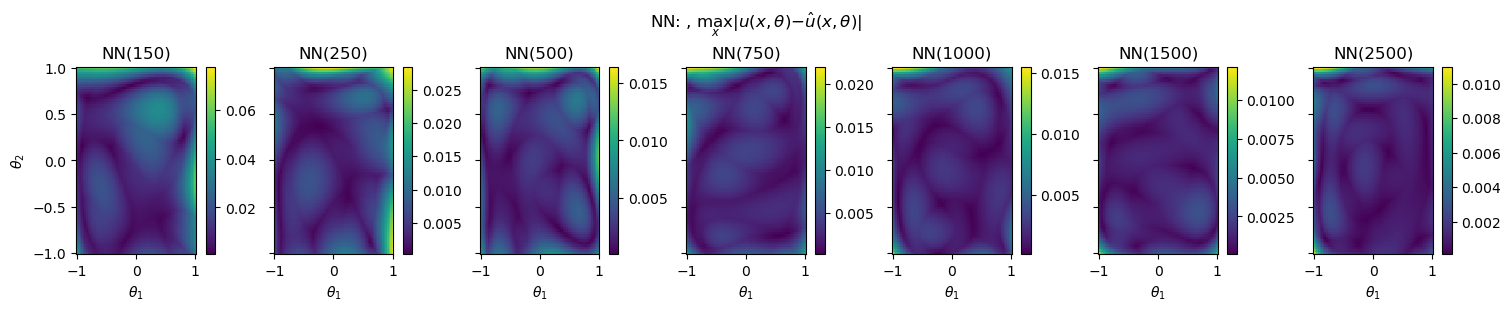

[0.01611701 0.00579275 0.00309188 0.00332786 0.00206926 0.00161969
 0.00134118]


In [5]:
plot_max_errors(N, results, X, Y, "")

print(results.mean(axis=(0,1)))

# Inverse Problem

In [13]:
# Define the model using a coarse FEM solver
def fem_surrogate(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def dgala_surrogate(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def nn_surrogate(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate.model(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

# Noisy Observations

In [9]:
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
obs_points, obs_sol = generate_noisy_obs(6,std=st)
hvert = 50

# MCMC

In [ ]:
config = get_deepgalerkin_config()

obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32), torch.tensor(obs_sol, dtype=torch.float32)
st = torch.sqrt(torch.tensor(vr,dtype=torch.float32)).to(device)

# # # Define the MCMC kernel (using Random Walk Metropolis)
# kernel = mcmc.RandomWalkKernel(fem_surrogate, target_accept_prob=0.234)

# # Create an MCMC object with the kernel
# mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# surrogate_fem_solver = FEMSolver(theta=np.zeros(2), vert=hvert)

# # Run the MCMC inference
# mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# # Get the results (posterior samples)
# samples = mcmc_sampler.get_samples()
# samples = samples["theta"].numpy()

# np.save(f'./results/FEM_pyro_h{hvert}_var{vr}.npy', samples)

# del kernel, mcmc_sampler, samples

for nobs in N:
    nn_surrogate_model = torch.load(f"./models/MDNN_s{nobs}.pth")
    nn_surrogate_model.eval()
    config.samples = nobs

#     kernel = mcmc.RandomWalkKernel(nn_surrogate, target_accept_prob=0.234)

#     mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(nn_surrogate_model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./results/MDNN_s{nobs}_noise{vr}.npy', samples)
#     del kernel, mcmc_sampler, samples

    #### Deep GaLA

    data_parameters = samples_param(config.samples*2, nparam=config.nparameters)
    
    param_train, param_test = data_parameters[:config.samples,:],  data_parameters[config.samples:,:]

    data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


    data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
                "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
                "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    llp = dgala(nn_surrogate_model)

    llp.fit(data_trainig)

    llp.optimize_marginal_likelihood()

    kernel = mcmc.RandomWalkKernel(dgala_surrogate, target_accept_prob=0.234)

    mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    print("Initializing MCMC")
    mcmc_sampler.run(llp,obs_sol,obs_points,st)

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./results/dGaLA_s{nobs}_noise{vr}.npy', samples)
    del kernel, mcmc_sampler, samples

Iteration 100, Error: 0.00977, neg_marglik: 37.82544
Iteration 200, Error: 0.00882, neg_marglik: -389.97574
Iteration 300, Error: 0.00647, neg_marglik: -764.51276
Maximum iterations (300)reached, sigma : 0.05356171727180481, prior: 11.944536209106445.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [22:48, 734.33it/s, step size=1.50e-01, acc. prob=0.227]


Iteration 100, Error: 0.00975, neg_marglik: 18.97585
Iteration 200, Error: 0.00874, neg_marglik: -709.89136
Iteration 300, Error: 0.00656, neg_marglik: -1392.00598
Maximum iterations (300)reached, sigma : 0.05187401920557022, prior: 11.309439659118652.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:07, 792.60it/s, step size=1.26e-01, acc. prob=0.230]


Iteration 100, Error: 0.00972, neg_marglik: -26.87213
Iteration 200, Error: 0.00870, neg_marglik: -1508.62842
Iteration 300, Error: 0.00674, neg_marglik: -2962.38257
Maximum iterations (300)reached, sigma : 0.05070731043815613, prior: 11.018314361572266.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:19, 785.69it/s, step size=1.22e-01, acc. prob=0.237]


Iteration 100, Error: 0.00964, neg_marglik: -79.19411
Iteration 200, Error: 0.00839, neg_marglik: -2307.06396
Iteration 300, Error: 0.00628, neg_marglik: -4486.03369
Maximum iterations (300)reached, sigma : 0.05080720782279968, prior: 9.730432510375977.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:40, 773.03it/s, step size=1.20e-01, acc. prob=0.238]


Iteration 100, Error: 0.00966, neg_marglik: -128.19849
Iteration 200, Error: 0.00850, neg_marglik: -3108.55615
Iteration 300, Error: 0.00648, neg_marglik: -6054.71533
Maximum iterations (300)reached, sigma : 0.05054648593068123, prior: 10.142011642456055.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:41, 772.35it/s, step size=1.18e-01, acc. prob=0.238]


Iteration 100, Error: 0.00968, neg_marglik: -227.38416
Iteration 200, Error: 0.00858, neg_marglik: -4708.65234
Iteration 300, Error: 0.00661, neg_marglik: -9160.50977
Maximum iterations (300)reached, sigma : 0.05043128877878189, prior: 10.428465843200684.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:41, 772.41it/s, step size=1.16e-01, acc. prob=0.241]


Iteration 100, Error: 0.00968, neg_marglik: -437.55191
Iteration 200, Error: 0.00858, neg_marglik: -7916.80664
Iteration 300, Error: 0.00662, neg_marglik: -15352.75684
Maximum iterations (300)reached, sigma : 0.05042032152414322, prior: 10.449127197265625.
Initializing MCMC


Sample: 100%|██████████| 1005000/1005000 [21:39, 773.10it/s, step size=1.16e-01, acc. prob=0.239]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

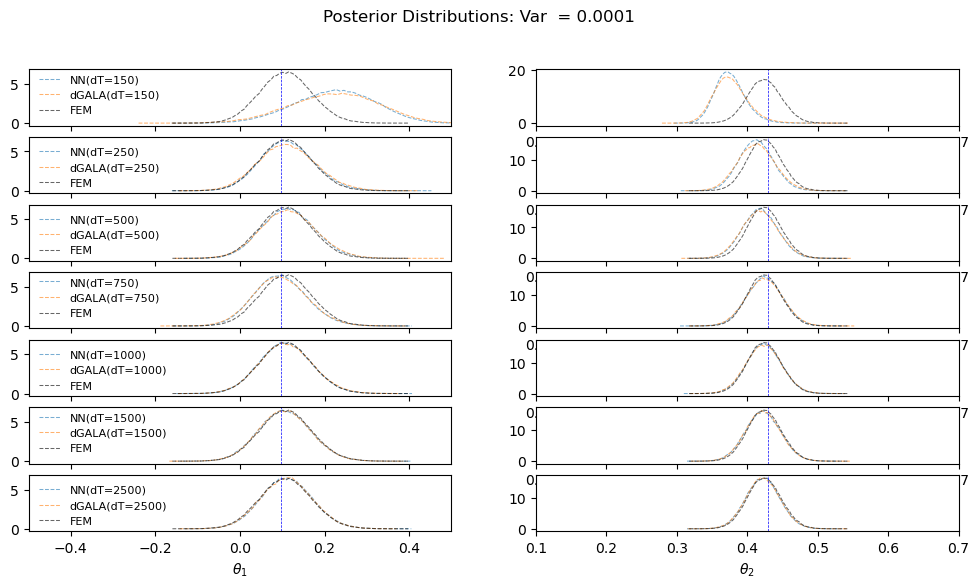

In [17]:
bins =80
vr = 1e-4
theta_th=np.array([0.098, 0.430])

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/MDNN_s{nobs}_noise{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./results/dGaLA_s{nobs}_noise{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_pyro_h{hvert}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

# Same Experiment var=1e-5

In [3]:
vr = 1e-5
st = torch.sqrt(torch.tensor(vr))
obs_points, obs_sol = generate_noisy_obs(6,std=st)
hvert = 50

In [21]:
config = get_deepgalerkin_config()

obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32), torch.tensor(obs_sol, dtype=torch.float32)
st = torch.sqrt(torch.tensor(vr,dtype=torch.float32)).to(device)

# # # Define the MCMC kernel (using Random Walk Metropolis)
kernel = mcmc.RandomWalkKernel(fem_surrogate, target_accept_prob=0.234)

# Create an MCMC object with the kernel
mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

surrogate_fem_solver = FEMSolver(theta=np.zeros(2), vert=hvert)

# Run the MCMC inference
mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./results/FEM_pyro_h{hvert}_var{vr}.npy', samples)

del kernel, mcmc_sampler, samples

for nobs in N:
    nn_surrogate_model = torch.load(f"./models/MDNN_s{nobs}.pth")
    nn_surrogate_model.eval()
    config.samples = nobs

    kernel = mcmc.RandomWalkKernel(nn_surrogate, target_accept_prob=0.234)

    mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    mcmc_sampler.run(nn_surrogate_model,obs_sol,obs_points,st)

    # Get the results (posterior samples)
    samples = mcmc_sampler.get_samples()
    samples = samples["theta"].numpy()

    np.save(f'./results/MDNN_s{nobs}_noise{vr}.npy', samples)
    del kernel, mcmc_sampler, samples

    #### Deep GaLA

    # data_parameters = samples_param(config.samples*2, nparam=config.nparameters)
    
    # param_train, param_test = data_parameters[:config.samples,:],  data_parameters[config.samples:,:]

    # data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    # data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


    # data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
    #             "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
    #             "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    # llp = dgala(nn_surrogate_model)

    # llp.fit(data_trainig)

    # llp.optimize_marginal_likelihood()

    # kernel = mcmc.RandomWalkKernel(dgala_surrogate, target_accept_prob=0.234)

    # mcmc_sampler = mcmc.MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    # print("Initializing MCMC")
    # mcmc_sampler.run(llp,obs_sol,obs_points,st)

    # # Get the results (posterior samples)
    # samples = mcmc_sampler.get_samples()
    # samples = samples["theta"].numpy()

    # np.save(f'./results/dGaLA_s{nobs}_noise{vr}.npy', samples)
    # del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [08:07, 2061.83it/s, step size=1.58e-02, acc. prob=0.164]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

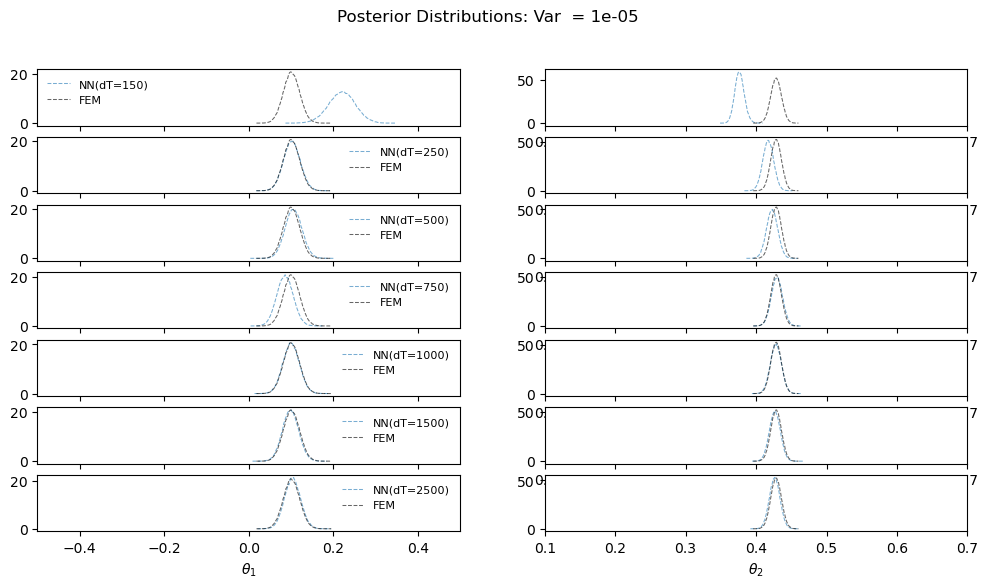

In [6]:
bins =80
vr = 1e-5
theta_th=np.array([0.098, 0.430])

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./results/MDNN_s{nobs}_noise{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    # sample = np.load(f'./results/dGaLA_s{nobs}_noise{vr}.npy')

    # bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    # axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    # bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    # axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./results/FEM_pyro_h{hvert}_var{vr}.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    #axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    #axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

In [ ]:


# Solve the FEM problem using the given theta values and roots
solver = FEMSolver(theta_th,vert=vert)
solution = solver.solve()

# Extract observation points and the solution points
obs_points, sol_points = solver.solution_array()

# Choose indices for the observation points, including start and end
obs_points = np.linspace(0.2,0.8,obs).reshape(-1,1)

# Select the observation and solution points based on the indices
sol_points = solver.eval_at_points(obs_points)

# Generate noise and add it to the solution points
noise_sol_points = add_noise(sol_points, mean, std)

# Ensure proper reshaping of observation and solution points
obs_points = obs_points.reshape(-1, 1)
sol_test = noise_sol_points.reshape(-1, 1)


def add_noise(solution, mean, std, seed = 0):
    """
    Adds Gaussian noise to the solution.
    """
    rng = np.random.default_rng(seed)
    noise = rng.normal(mean, std, solution.shape)
    return solution + noise


In [19]:
rng = np.random.default_rng(0)
noise = rng.normal(0, 10**(-k/2), dy)
noise

array([ 0.0012573 , -0.00132105,  0.00640423,  0.001049  , -0.00535669,
        0.00361595])

In [20]:
dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)
eta

array([ 0.01764052,  0.00400157,  0.00978738,  0.02240893,  0.01867558,
       -0.00977278])

In [ ]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC


from MetropolisHastings import MetropolisHastingsSampler,MoreauYosidaPrior
from FEM_Solver import  RootFinder,FEMSolver
from utilities import *

import matplotlib.pyplot as plt

from NN import DNN
from GaLa import llaplace
from GaLa2 import llaplace as llaplace2

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Computing Roots

In [5]:
lam = 1 / 4
M = 2

finder = RootFinder(lam, M)
roots = finder.find_roots()

print("Roots:", roots)

Roots: [2.15374797 4.57785946]


In [11]:
def k_function(data_domain,w=roots):
    x = data_domain[:,0].reshape(-1,1)
    theta = data_domain[:,1:].reshape(x.shape[0],-1)

    A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
    bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))

    an = torch.sqrt(8 / (w**2 + 16))

    return torch.sum(an*bn*theta,dim=1)

def de(self,data_domain,k = k_function,roots = torch.tensor(roots,dtype=float).reshape(1,-1)):
    """ The pytorch autograd version of calculating residual """
    data_domain = data_domain.requires_grad_(True)

    u = self(data_domain)

    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        #retain_graph=True,
        create_graph=True
    )[0]

    k = k(data_domain,roots)
    
    ddu_x = torch.autograd.grad(
        torch.exp(k).reshape(-1,1)*du[:,0].reshape(-1,1),data_domain, 
        grad_outputs=torch.ones_like(du[:,0].reshape(-1,1)),
        #retain_graph=True,
        create_graph=True
        )[0]
        
    return ddu_x[:,0].reshape(-1,1) + 4*data_domain[:,0].reshape(-1,1)


def bc_l(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)

def bc_r(self,data_bc):
    u = self(data_bc)
    return u.reshape(-1,1)- 2

DNN.de = de
DNN.bc_l = bc_l
DNN.bc_r = bc_r

WRF_MDNN.de = de
WRF_MDNN.bc_l = bc_l
WRF_MDNN.bc_r = bc_r

WRFNN.de = de
WRFNN.bc_l = bc_l
WRFNN.bc_r = bc_r

MDNN.de = de
MDNN.bc_l = bc_l
MDNN.bc_r = bc_r

In [12]:
def generate_data(size, param = None, nparam = 2, seed = 65647437836358831880808032086803839626):
        #x = lhs(1, size).reshape(-1, 1)  # Latin Hypercube Sampling for x
        sampler = qmc.LatinHypercube(d=1, seed=seed)
        x = sampler.random(n=size)

        if param is None:
            param = samples_param(size=size, nparam= nparam)
        else:
            param = param[:size,:]

        x_tensor = torch.Tensor(x)
        param_tensor = torch.Tensor(param)

        data_int = torch.cat([x_tensor, param_tensor], axis=1).float()
        left_bc = torch.cat([torch.zeros_like(x_tensor).float(), param_tensor], axis=1).float()
        right_bc = torch.cat([torch.ones_like(x_tensor).float(), param_tensor], axis=1).float()

        return data_int, left_bc, right_bc  

In [13]:
def compute_loss(pinn, data_int, left_bc, right_bc, loss_fn):
    """Compute the total loss for given data."""
    pde_pred = pinn.de(data_int)
    left_bc_pred = pinn.bc_l(left_bc)
    right_bc_pred = pinn.bc_r(right_bc)

    zeros = torch.zeros_like(pde_pred)

    loss_pde = loss_fn(pde_pred, zeros)
    loss_lbc = loss_fn(left_bc_pred, zeros)
    loss_rbc = loss_fn(right_bc_pred, zeros)

    total_loss = loss_pde + loss_lbc + loss_rbc
    return total_loss, loss_pde, loss_lbc, loss_rbc


In [19]:
# Number of observations
epochs = 5000
lr = 0.001
decay_rate = 0.95   # Decay rate for exponential scheduler
scheduler_step_epochs = 50  # Number of epochs to wait before stepping the scheduler
start_scheduler_epoch = int(epochs * 0.5) 

layers = [3] + 4*[256] + [1]

models = {"NN":DNN(layers),
          "WRF_MDNN":WRF_MDNN(num_layers=4, hidden_dim=256, out_dim=1, activation="tanh", 
            fourier_emb=None, input_dim=3, reparam={"type":"weight_fact", "mean": 1.0, "stddev":0.1}),
          "WRF":WRFNN(layers),
          "MDNN":MDNN(num_layers=4, hidden_dim=256, out_dim=1, activation="tanh", 
            fourier_emb=None, input_dim=3)}

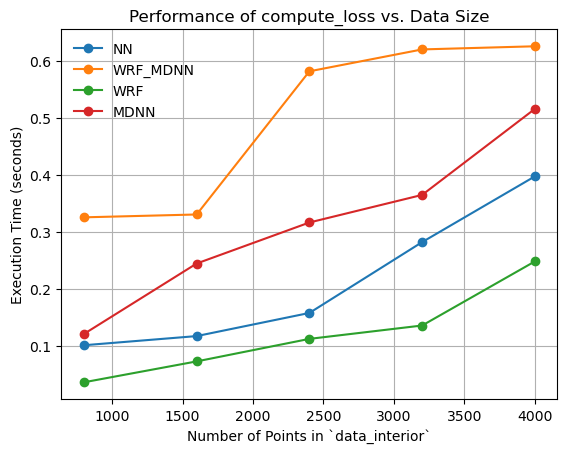

In [20]:
import time
import matplotlib.pyplot as plt

loss_fn = torch.nn.MSELoss(reduction ='mean')

sizes = [16*i for i in range(50,300,50)]  # Varying number of points in `data_interior`
times = {"NN":[],"WRF_MDNN":[],"WRF":[],"MDNN":[]}

for model in models.keys():
    for size in sizes:
        data_int, left_bc, right_bc   = generate_data(size=size)

        start_time = time.time()
        total_loss, _, _,_ = compute_loss(models[model], data_int, left_bc, right_bc,loss_fn)
        end_time = time.time()
        times[model].append(end_time - start_time)

# Plot Results
for model in models.keys():
    plt.plot(sizes, times[model], marker='o',label = model)

plt.xlabel('Number of Points in `data_interior`')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance of compute_loss vs. Data Size')
plt.legend(frameon = False)
plt.grid(True)
plt.show()

In [ ]:
# torch.manual_seed(42)

# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# # Initialize DNN with Fourier embeddings, weight factorization, and Glorot initialization

# dataset = dGDataset(size = 2500, param=param_train)

# x_val,param_val, sol_val = generate_test_data(2500,param =param_test, vert=30)

# dataloader = DataLoader(dataset, batch_size=150, shuffle=False)

# loss = torch.nn.MSELoss(reduction ='mean')

# for name,model in models.items():

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Exponential decay scheduler


#     print(f"Starting Adam Training for model {name}")

#     train_loss, test_loss = [], []

#     for epoch in range(epochs):
#         epoch_train_loss = 0.0  # Accumulate loss over all batches for this epoch
        
#         for data_int, left_bc, right_bc in dataloader:
#             data_int, left_bc, right_bc = data_int.to(device), left_bc.to(device), right_bc.to(device)

#             data_int = Variable(data_int, requires_grad=True)
#             left_bc, right_bc = Variable(left_bc, requires_grad=True), Variable(right_bc, requires_grad=True)
            
#             optimizer.zero_grad()

#             total_loss, loss_pde, loss_lbc, loss_rbc = compute_loss(model, data_int, left_bc, right_bc, loss)

#             total_loss.backward(retain_graph=True)
#             optimizer.step()
            
#             # Accumulate the batch loss into the epoch loss
#             epoch_train_loss += total_loss.item()

#         # Calculate the average loss for the epoch
#         epoch_train_loss /= len(dataloader)
#         train_loss.append(epoch_train_loss)

#         # Compute the test loss at the end of the epoch
#         test_loss_current = compute_mean_error(model,param_val,x_val,sol_val)
#         test_loss.append(test_loss_current)

        
#         # Scheduler step only in the last 25% of epochs, every `scheduler_step_epochs`
#         if epoch >= start_scheduler_epoch and (epoch - start_scheduler_epoch) % scheduler_step_epochs == 0:
#             scheduler.step()

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.5e}, Test Loss: {test_loss_current:.5e}')
        

#     np.save(f'./Models/{name}_train_N{2500}_batch{150}.npy', np.array(train_loss))
#     np.save(f'./Models/{name}_test_N{2500}_batch{150}.npy', np.array(test_loss)) 

#     path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
#     torch.save(model.state_dict(),path)

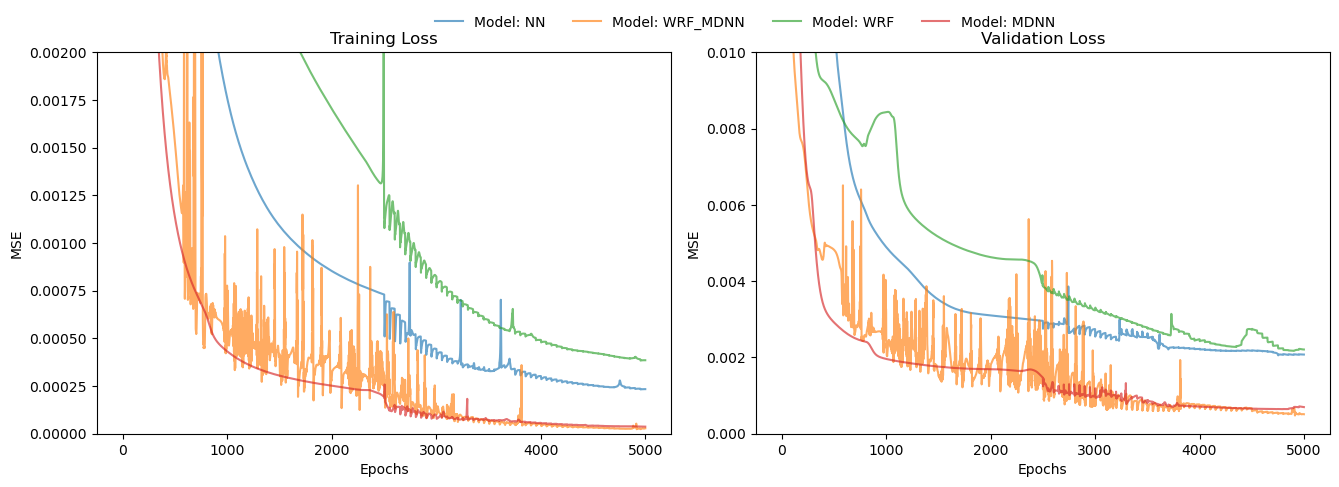

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5 ))

for name in models.keys():
# Loop through each batch size in sample_size
    # Load the data for ADAM optimizer (training and validation loss)
    adam_train_loss = np.load(f'./Models/{name}_train_N{2500}_batch{150}.npy')
    adam_test_loss = np.load(f'./Models/{name}_test_N{2500}_batch{150}.npy')

    # Plot Training Loss for ADAM optimizer
    axs[0].plot(adam_train_loss, label=f"Model: {name}", alpha = 0.65)
    axs[0].set_title(f"Training Loss")
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim(0,0.002)

    # Plot Validation Loss for ADAM optimizer
    axs[1].plot(adam_test_loss, label=f"Model: {name}", alpha = 0.65)
    axs[1].set_title(f"Validation Loss")
    axs[1].set_ylabel("MSE")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylim(0,0.01)
# Add a global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(models.keys()), frameon=False, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.95])


In [7]:
grid = 75
vert = 50
parameter  = np.linspace(-1,1,grid)

# Initialize results array
results = np.zeros((grid, grid, len(models.keys())))

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(2), vert = vert)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        data = torch.tensor(np.hstack((x_FEM, np.ones((x_FEM.shape[0], pr.shape[0])) * pr))).float()

        for z, (name, model) in enumerate(models.items()):

            model_path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
            model.load_state_dict(torch.load(model_path))
            model.eval()

            surg = model(data).detach().cpu().numpy().reshape(-1, 1)

            # Compute the maximum error between FEM and surrogate
            max_error = np.max(np.abs(y_FEM - surg))
            results[i, j, z] = max_error

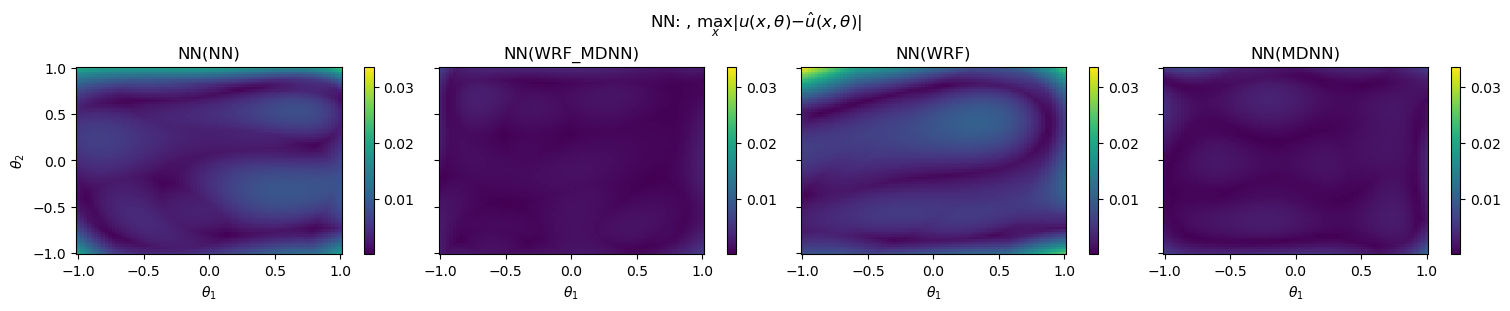

[0.00493473 0.00114548 0.00554597 0.00144679]


In [8]:
plot_max_errors(list(models.keys()), results, X, Y, "")

print(results.mean(axis=(0,1)))

In [9]:
for z, (name, model) in enumerate(models.items()):

    model_path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()

    total_params = sum(p.numel() for p in model.parameters())

    print(f"Total parameters model {name}: {total_params}")

Total parameters model NN: 521
Total parameters model WRF_MDNN: 762
Total parameters model WRF: 521
Total parameters model MDNN: 681


In [10]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# # Define the model using a coarse FEM solver
# def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
#     # Prior for the parameters theta (assuming 2 parameters)
#     theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


#     # Use a coarse mesh FEM solver as the surrogate model
#     surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

#     surrogate_fem_solver.uh = None

#     surrogate_fem_solver.solve()

#     # Get model predictions at the given points
#     model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

#     # Likelihood: Gaussian likelihood with a fixed standard deviation
#     y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

#     return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [11]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
eta = np.random.normal(0,10**(-k/2),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])
y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [12]:
torch.set_rng_state(original_state_pytorch)


theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))

# #obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

# obs_points, obs_sol = torch.tensor(X), torch.tensor(y)
# # Define the MCMC kernel (using Random Walk Metropolis)

# st = torch.sqrt(torch.tensor(vr).float().to(device))    
# # Define the MCMC kernel (using Random Walk Metropolis)

# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

# st = torch.sqrt(torch.tensor(vr))

# for z, (name, model) in enumerate(models.items()):

#     model_path = f"./Models/1dElliptic_{name}_N{2500}_batch{150}.pt"
#     model.load_state_dict(torch.load(model_path))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/{name}_var{vr}_{2500}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

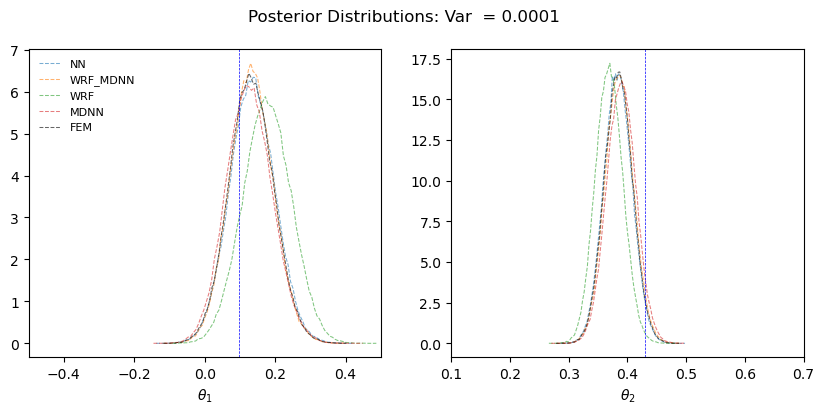

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")
bins =80
hvert = 50
vr = 1e-4


for name in models.keys():
    sample = np.load(f'./Models/{name}_var{vr}_{2500}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"{name}")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"{name}")


sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{10}_tiaming.npy')

bin_centers, counts = histogram_(sample[:, 0],bins=bins)
axs[0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
axs[1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")

axs[0].legend(frameon = False, fontsize =8)
axs[0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
axs[1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

axs[1].set_xlim((0.1,0.7)),axs[0].set_xlim((-0.5,0.5))

axs[0].set_xlabel("$\\theta_{1}$"),axs[1].set_xlabel("$\\theta_{2}$")


# Experiment with DNN

In [12]:
# Number of observations
epochs = 5000
lr = 0.001
decay_rate = 0.95   # Decay rate for exponential scheduler
scheduler_step_epochs = 50  # Number of epochs to wait before stepping the scheduler
start_scheduler_epoch = int(epochs * 0.5) 

layers = [3] + 2*[20] + [1]

N = [150,250,500,750,1000,1500,2500]


In [ ]:
# torch.manual_seed(42)

# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# # Initialize DNN with Fourier embeddings, weight factorization, and Glorot initialization
# for nobs in N:
#     dataset = dGDataset(size = nobs, param=param_train)

#     x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)


#     dataloader = DataLoader(dataset, batch_size=150, shuffle=False)

#     loss = torch.nn.MSELoss(reduction ='mean')

#     model = DNN(layers)

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Exponential decay scheduler


#     print(f"Starting Adam Training for model {DNN}")

#     train_loss, test_loss = [], []

#     for epoch in range(epochs):
#         epoch_train_loss = 0.0  # Accumulate loss over all batches for this epoch
        
#         for data_int, left_bc, right_bc in dataloader:
#             data_int, left_bc, right_bc = data_int.to(device), left_bc.to(device), right_bc.to(device)

#             data_int = Variable(data_int, requires_grad=True)
#             left_bc, right_bc = Variable(left_bc, requires_grad=True), Variable(right_bc, requires_grad=True)
            
#             optimizer.zero_grad()

#             total_loss, loss_pde, loss_lbc, loss_rbc = compute_loss(model, data_int, left_bc, right_bc, loss)

#             total_loss.backward(retain_graph=True)
#             optimizer.step()
            
#             # Accumulate the batch loss into the epoch loss
#             epoch_train_loss += total_loss.item()

#         # Calculate the average loss for the epoch
#         epoch_train_loss /= len(dataloader)
#         train_loss.append(epoch_train_loss)

#         # Compute the test loss at the end of the epoch
#         test_loss_current = compute_mean_error(model,param_val,x_val,sol_val)
#         test_loss.append(test_loss_current)

        
#         # Scheduler step only in the last 25% of epochs, every `scheduler_step_epochs`
#         if epoch >= start_scheduler_epoch and (epoch - start_scheduler_epoch) % scheduler_step_epochs == 0:
#             scheduler.step()

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.5e}, Test Loss: {test_loss_current:.5e}')
        

#     np.save(f'./Models/DNN_train_N{nobs}_batch{150}.npy', np.array(train_loss))
#     np.save(f'./Models/DNN_test_N{nobs}_batch{150}.npy', np.array(test_loss)) 

#     path = f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"
#     torch.save(model.state_dict(),path)

Starting Adam Training for model <class 'NN.DNN'>
Epoch 0, Train Loss: 1.03630e+01, Test Loss: 1.12188e+00
Epoch 10, Train Loss: 7.99600e+00, Test Loss: 8.12223e-01
Epoch 20, Train Loss: 6.51100e+00, Test Loss: 5.53472e-01
Epoch 30, Train Loss: 5.70183e+00, Test Loss: 3.92574e-01
Epoch 40, Train Loss: 5.25593e+00, Test Loss: 3.30222e-01
Epoch 50, Train Loss: 4.89157e+00, Test Loss: 2.99905e-01
Epoch 60, Train Loss: 4.54807e+00, Test Loss: 2.80937e-01
Epoch 70, Train Loss: 4.23809e+00, Test Loss: 2.72651e-01
Epoch 80, Train Loss: 3.96119e+00, Test Loss: 2.71822e-01
Epoch 90, Train Loss: 3.69454e+00, Test Loss: 2.73274e-01
Epoch 100, Train Loss: 3.39434e+00, Test Loss: 2.69844e-01
Epoch 110, Train Loss: 3.01979e+00, Test Loss: 2.58258e-01
Epoch 120, Train Loss: 2.56949e+00, Test Loss: 2.39003e-01
Epoch 130, Train Loss: 2.11276e+00, Test Loss: 2.15790e-01
Epoch 140, Train Loss: 1.76438e+00, Test Loss: 1.92144e-01
Epoch 150, Train Loss: 1.54619e+00, Test Loss: 1.70261e-01
Epoch 160, Train 

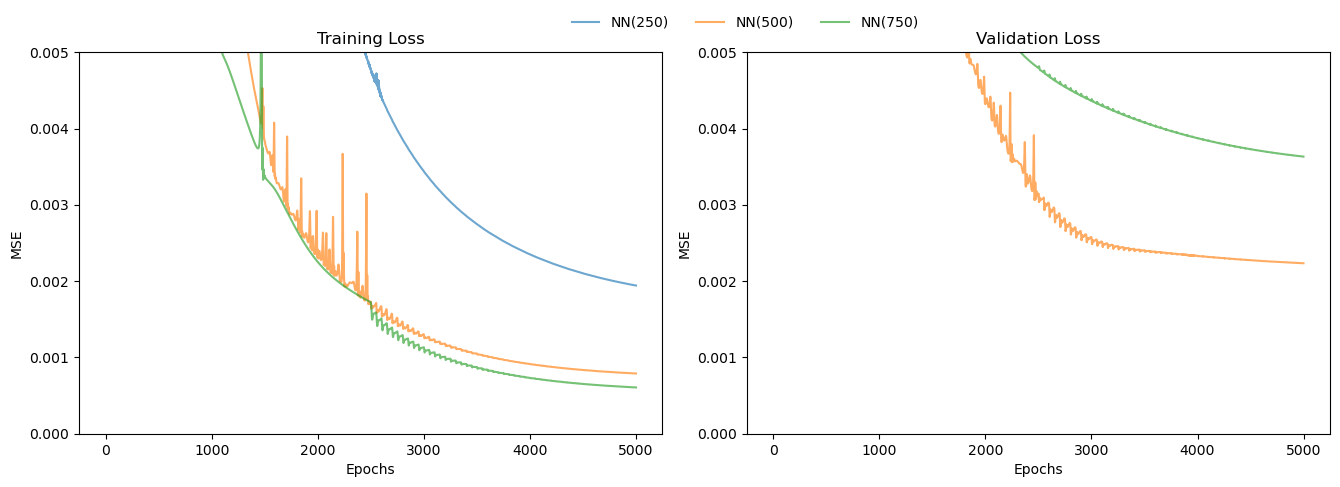

In [8]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5 ))

for nobs in N:
# Loop through each batch size in sample_size
    # Load the data for ADAM optimizer (training and validation loss)
    adam_train_loss = np.load(f'./Models/DNN_train_N{nobs}_batch{150}.npy')
    adam_test_loss = np.load(f'./Models/DNN_test_N{nobs}_batch{150}.npy')

    # Plot Training Loss for ADAM optimizer
    axs[0].plot(adam_train_loss, label=f"NN({nobs})", alpha = 0.65)
    axs[0].set_title(f"Training Loss")
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylim(0,0.005)

    # Plot Validation Loss for ADAM optimizer
    axs[1].plot(adam_test_loss, label=f"NN({nobs})", alpha = 0.65)
    axs[1].set_title(f"Validation Loss")
    axs[1].set_ylabel("MSE")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylim(0,0.005)
# Add a global legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.9), ncol=len(models.keys()), frameon=False, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

In [18]:
grid = 75
vert = 50
parameter  = np.linspace(-1,1,grid)

# Initialize results array
results = np.zeros((grid, grid, len(models.keys())))

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(2), vert = vert)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        data = torch.tensor(np.hstack((x_FEM, np.ones((x_FEM.shape[0], pr.shape[0])) * pr))).float()

        for z, nobs in enumerate(N):

            model_path =  f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"
            model = DNN(layers)
            model.load_state_dict(torch.load(model_path))
            model.eval()

            surg = model(data).detach().cpu().numpy().reshape(-1, 1)

            # Compute the maximum error between FEM and surrogate
            max_error = np.max(np.abs(y_FEM - surg))
            results[i, j, z] = max_error

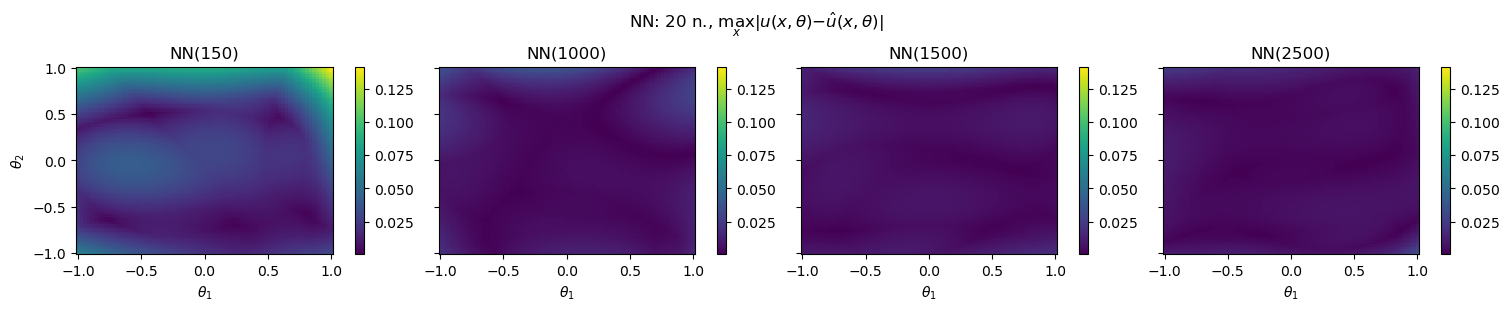

[0.02875376 0.00741002 0.00626378 0.00505031]


In [19]:
plot_max_errors(N, results, X, Y, "20 n.")

print(results.mean(axis=(0,1)))

# deepGaLA

In [11]:
nobs, hl, w = 500, 2, 20

layers = [3] + 2*[20] + [1]

model = DNN(layers).to(device)
model.load_state_dict(torch.load(f"./Models/1dElliptic_adam_PDE2_hiddenl{hl}_w{w}_N{nobs}_batch150.pt"))
model.eval()

##### Deep GaLA

data_parameters = samples_param(5000, nparam=2)
param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

pde = {"PDE":["de","bc_l","bc_r"], 
    "data_set":{"de" : Variable(data_int,requires_grad=True),
    "bc_l":left_bc,
    "bc_r" :right_bc}}

llp2 = llaplace2(model)

llp2.fit(pde=pde, hessian_structure = "full")

In [27]:
prior_list =[]
sigma_list = []
prior = 1
sigma  = 1
error_tolerance=1e-12
max_iter=500
lr=1e-2

log_prior  = torch.ones(prior, requires_grad=True)
log_sigma = torch.ones(sigma, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=lr)

error,n_iter = float('inf'),0  # Initialize error

while error > error_tolerance and n_iter < max_iter:
    prev_log_prior, prev_log_sigma = log_prior.detach().clone(), log_sigma.detach().clone()

    prior_list.append(prev_log_prior)
    sigma_list.append(prev_log_sigma)

    hyper_optimizer.zero_grad()

    # Calculate negative marginal likelihood
    neg_marglik = -llp2.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)

    # Perform optimization step
    hyper_optimizer.step()

    # Calculate the error based on the change in hyperparameters
    error = 0.5 * (torch.abs(log_prior - prev_log_prior) + torch.abs(log_sigma - prev_log_sigma)).item()

    n_iter += 1

    # Optional: log progress for monitoring
    if n_iter % 100 == 0:
        print(f"Iteration {n_iter}, Error: {error:.5f}, neg_marglik: {neg_marglik.item():.5f}")

if n_iter == max_iter:
    print(f"Maximum iterations ({max_iter})reached.")
print(f"Sigma : {llp2.sigma_noise.item()}, Prior: {llp2.prior_precision.item()}.")

Iteration 100, Error: 0.00852, neg_marglik: 526.95911
Iteration 200, Error: 0.00501, neg_marglik: 145.11911
Iteration 300, Error: 0.00125, neg_marglik: 27.35854
Iteration 400, Error: 0.00003, neg_marglik: 25.18629
Sigma : 0.22326579689979553, Prior: 11.632596015930176.


Text(0.5, 1.0, 'Sigma ($\\sigma$)')

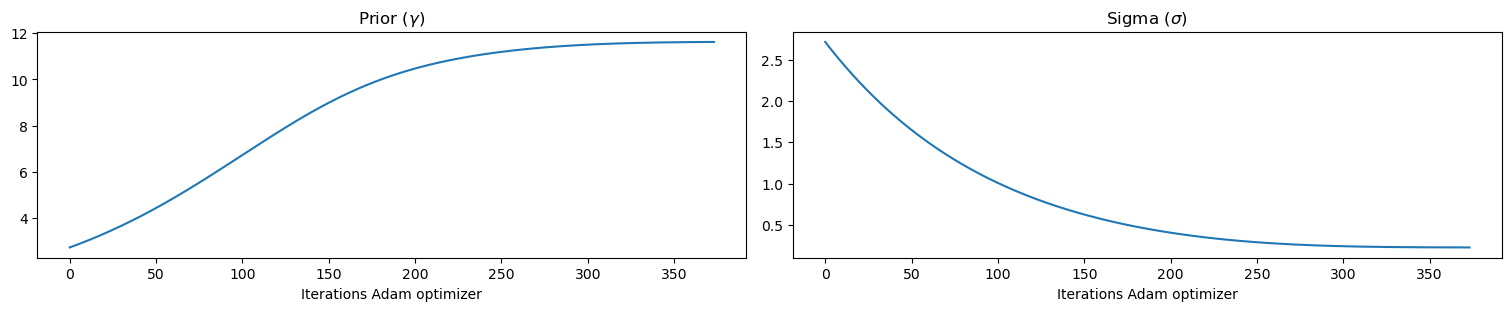

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3), layout="constrained")

axs[0].set_title("Prior ($\gamma$)")
axs[0].set_xlabel("Iterations Adam optimizer")
axs[0].plot(np.exp(np.array(prior_list)))
axs[1].plot(np.exp(np.array(sigma_list)))
axs[1].set_xlabel("Iterations Adam optimizer")
axs[1].set_title("Sigma ($\sigma$)")

In [40]:
laplace_models  = dict()

layers = [3] + 2*[20] + [1]

data_parameters = samples_param(5000, nparam=2)
param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]


for nobs in N:

    model = DNN(layers).to(device)
    model.load_state_dict(torch.load(f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"))
    model.eval()

    ##### Deep GaLA
    data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

    pde = {"PDE":["de","bc_l","bc_r"], 
        "data_set":{"de" : Variable(data_int,requires_grad=True),
        "bc_l":left_bc,
        "bc_r" :right_bc}}

    llp2 = llaplace2(model)

    llp2.fit(pde=pde, hessian_structure = "full")

    llp2.optimize_marginal_likelihood(max_iter=300)

    laplace_models[str(nobs)] = llp2

Iteration 100, Error: 0.00913, neg_marglik: 50.15748
Iteration 200, Error: 0.00526, neg_marglik: -31.48352
Iteration 100, Error: 0.00923, neg_marglik: 22.37305
Iteration 200, Error: 0.00685, neg_marglik: -905.76587
Iteration 300, Error: 0.00366, neg_marglik: -1555.72974
Maximum iterations (300)reached, sigma : 0.059950608760118484, prior: 6.120851993560791.
Iteration 100, Error: 0.00936, neg_marglik: -10.87695
Iteration 200, Error: 0.00734, neg_marglik: -1458.69104
Iteration 300, Error: 0.00472, neg_marglik: -2693.94653
Maximum iterations (300)reached, sigma : 0.05437938868999481, prior: 6.873943328857422.
Iteration 100, Error: 0.00860, neg_marglik: -79.00750
Iteration 200, Error: 0.00573, neg_marglik: -2513.19141
Iteration 300, Error: 0.00439, neg_marglik: -4661.87061
Maximum iterations (300)reached, sigma : 0.053507000207901, prior: 3.9860169887542725.


In [41]:
grid = 75
vert = 50
parameter  = np.linspace(-1,1,grid)

# Initialize results array
results = np.zeros((grid, grid,len(N)))

# Create meshgrid for plotting later
X, Y = np.meshgrid(parameter, parameter)

solver = FEMSolver(np.zeros(2), vert = vert)

# Main loop over parameter space
for i, par1 in enumerate(parameter):
    for j, par2 in enumerate(parameter):
        pr = np.array([par1, par2])

        # Update the solver with new parameter values
        solver.theta = pr  # Update the parameter vector
        solver.uh = None  # Reset the FEM solution
        solver.solve()

        # Get FEM solution arrays
        x_FEM, y_FEM = solver.solution_array()
        x_FEM, y_FEM = x_FEM[:, 0].reshape(-1, 1), y_FEM.reshape(-1, 1)

        # Loop over observation sizes N
        data = torch.tensor(np.hstack((x_FEM, np.ones((x_FEM.shape[0], pr.shape[0])) * pr))).float()

        for z,nobs in enumerate(N):
            llp = laplace_models[str(nobs)]

            u_mean, u_sigma = llp(data)
            
            u_mean, u_sigma = u_mean.detach().cpu().numpy(), u_sigma[:,:,0].detach().cpu().numpy()

            #Compute the maximum error between FEM and surrogate
            mean_var = np.mean(u_sigma)
            results[i, j,z] = mean_var


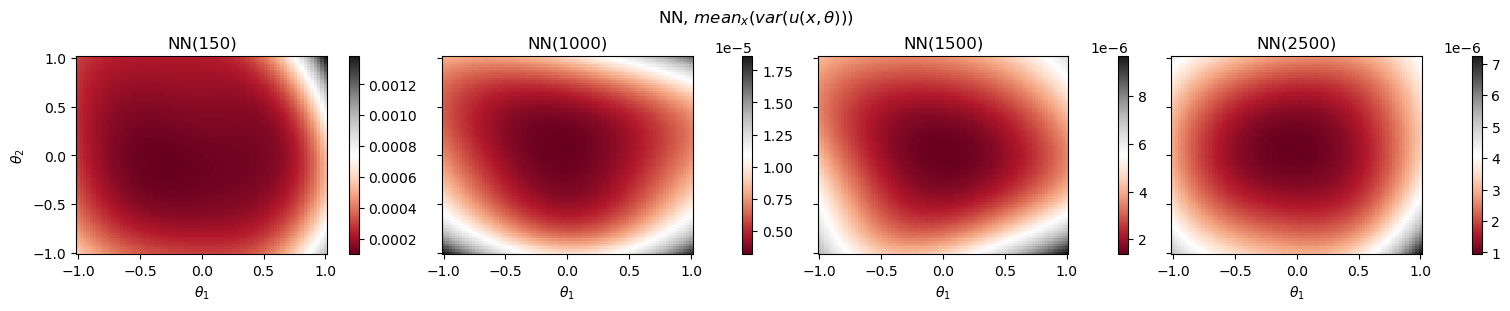

In [42]:
fig, axs = plt.subplots(1, len(N), figsize=(15, 3), layout="constrained", sharey=True)
fig.suptitle(fr"NN, $mean_{{x}} (var (u(x, \theta)))$", fontsize=12)

z_min, z_max = results.min(), results.max()

for z, key in enumerate(N):
    Z = results[:, :, z]  # Extract the results for current N

    # Set the color scale limits based on the first plot
    # Plot the heatmap for each N
    pcm = axs[z].pcolormesh(X, Y, Z, shading='auto', cmap = "RdGy")
    axs[z].set_xlabel(r"$\theta_1$")
    axs[z].set_title(f"NN({key})")
    plt.colorbar(pcm, ax=axs[z])

axs[0].set_ylabel(r"$\theta_2$")  # Set common y-axis label
plt.show()


# Pyro Uniform

# Inverse problem through MCMC

In [9]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from elliptic_files.FEM_Solver import  FEMSolver


# Define the model using a coarse FEM solver
def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1).float()

    surg_mu = surrogate.u(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [10]:
obs_points, sol_test = generate_noisy_obs(obs=6,
                                            std=np.sqrt(1e-4),
                                            theta_t=np.array([0.098, 0.430]),
                                            vert=50)

In [19]:
model = torch.load(f"./models/MDNN_s150.pth")
model.eval()

kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

mcmc_sampler.run(model,torch.tensor(sol_test),torch.tensor(obs_points),np.sqrt(1e-4))

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

Sample: 100%|██████████| 1005000/1005000 [08:17, 2019.73it/s, step size=1.31e-01, acc. prob=0.229]


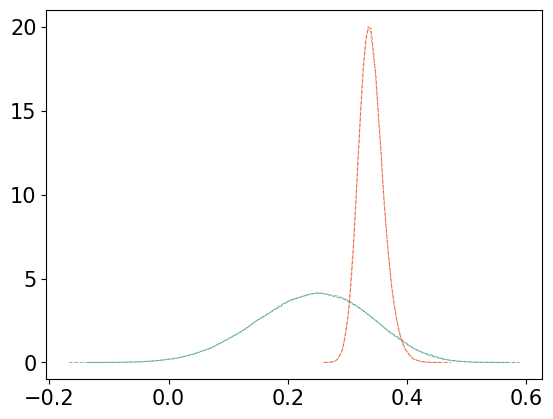

In [20]:
bin_centers, counts = histogram_(samples[:, 0],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
bin_centers, counts = histogram_(samples[:, 1],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

sample = np.load(f'./results/NN_ss{150}_var{vr}.npy')
bin_centers, counts = histogram_(sample[:, 0],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
bin_centers, counts = histogram_(sample[:, 1],bins=bins)
plt.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")


In [10]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
#eta = np.random.normal(0,10**(-k/2),dy)
eta = np.random.normal(0,np.sqrt(1e-4),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])

y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [ ]:

theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
hvert = 50

data_parameters = samples_param(5000, nparam=2)
param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

#obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)

obs_points, obs_sol = torch.tensor(X), torch.tensor(y)
# Define the MCMC kernel (using Random Walk Metropolis)

st = torch.sqrt(torch.tensor(vr).float().to(device))    
# # Define the MCMC kernel (using Random Walk Metropolis)
# kernel = mcmc.RandomWalkKernel(model, target_accept_prob=0.234)

# # Create an MCMC object with the kernel
# mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

# surrogate_fem_solver = FEMSolver(theta=np.zeros(theta_th.shape[0]), vert=hvert)

# # Run the MCMC inference
# mcmc_sampler.run(surrogate_fem_solver,obs_sol, obs_points,st)

# # Get the results (posterior samples)
# samples = mcmc_sampler.get_samples()
# samples = samples["theta"].numpy()

# np.save(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy', samples)


# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

# st = torch.sqrt(torch.tensor(vr))
# layers = [3] + 2*[20] + [1]

# for nobs in N:
#     model = DNN(layers).to(device)
#     model.load_state_dict(torch.load(f"./Models/1dElliptic_DNN_N{nobs}_batch{150}.pt"))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/DNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

#     #### Deep GaLA
#     data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
#     data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


#     pde = {"PDE":["de","bc_l","bc_r"], 
#         "data_set":{"de" : Variable(data_int,requires_grad=True),
#         "bc_l":left_bc,
#         "bc_r" :right_bc}}
    
#     llp2 = llaplace2(model)

#     start_time_mh = time.time()  # Start timing
#     llp2.fit(pde=pde, hessian_structure = "full")
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

#     start_time_mh = time.time()  # Start timing
#     llp2.optimize_marginal_likelihood()
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")
    
#     kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
#                      torch.tensor(obs_points).float().to(device),
#                      torch.sqrt(torch.tensor(vr).float().to(device)))

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [06:33, 2556.68it/s, step size=1.28e-01, acc. prob=0.222]


Total time for fitting: 0.004777284463246664
Iteration 100, Error: 0.00940, neg_marglik: 49.25685
Iteration 200, Error: 0.00691, neg_marglik: -151.03094
Iteration 300, Error: 0.00230, neg_marglik: -236.53088
Maximum iterations (300)reached, sigma : 0.07599138468503952, prior: 7.258443832397461.
Total time for optimizing: 0.01185534397761027


Sample: 100%|██████████| 1005000/1005000 [06:36, 2535.73it/s, step size=1.16e-01, acc. prob=0.239]


Total time for fitting: 0.014604139328002929
Iteration 100, Error: 0.00919, neg_marglik: 44.78545
Iteration 200, Error: 0.00669, neg_marglik: -408.53671
Iteration 300, Error: 0.00350, neg_marglik: -717.36493
Maximum iterations (300)reached, sigma : 0.0607309564948082, prior: 5.857875347137451.
Total time for optimizing: 0.011999861399332682


Sample: 100%|██████████| 1005000/1005000 [06:40, 2512.38it/s, step size=1.16e-01, acc. prob=0.240]


Total time for fitting: 0.03333561023076375
Iteration 100, Error: 0.00933, neg_marglik: 37.94294
Iteration 200, Error: 0.00719, neg_marglik: -663.48517
Iteration 300, Error: 0.00413, neg_marglik: -1192.85095
Maximum iterations (300)reached, sigma : 0.05773898959159851, prior: 6.720389366149902.
Total time for optimizing: 0.01398795445760091


Sample: 100%|██████████| 1005000/1005000 [18:27, 907.52it/s, step size=1.19e-01, acc. prob=0.239]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

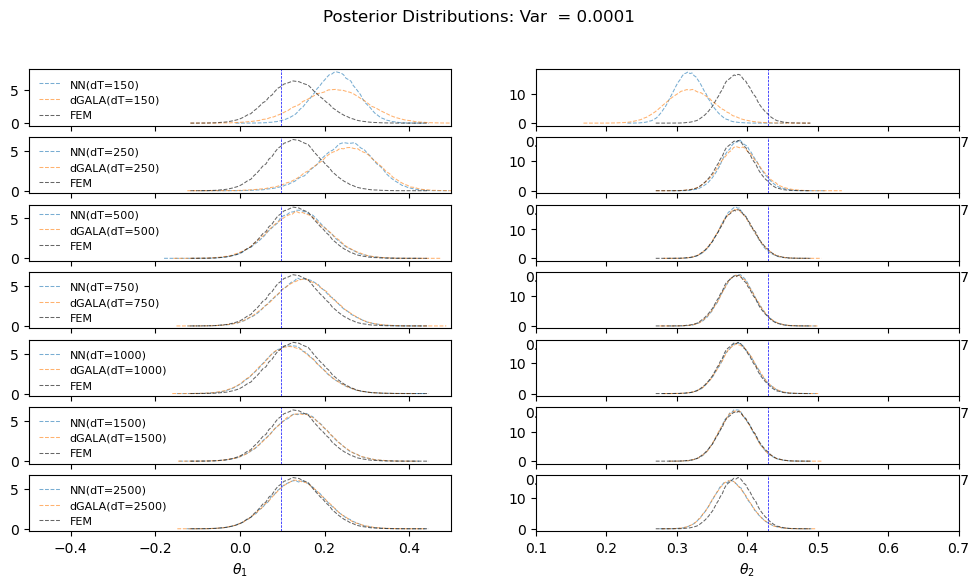

In [13]:
bins =80
vr = 1e-4

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./Models/DNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")



(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

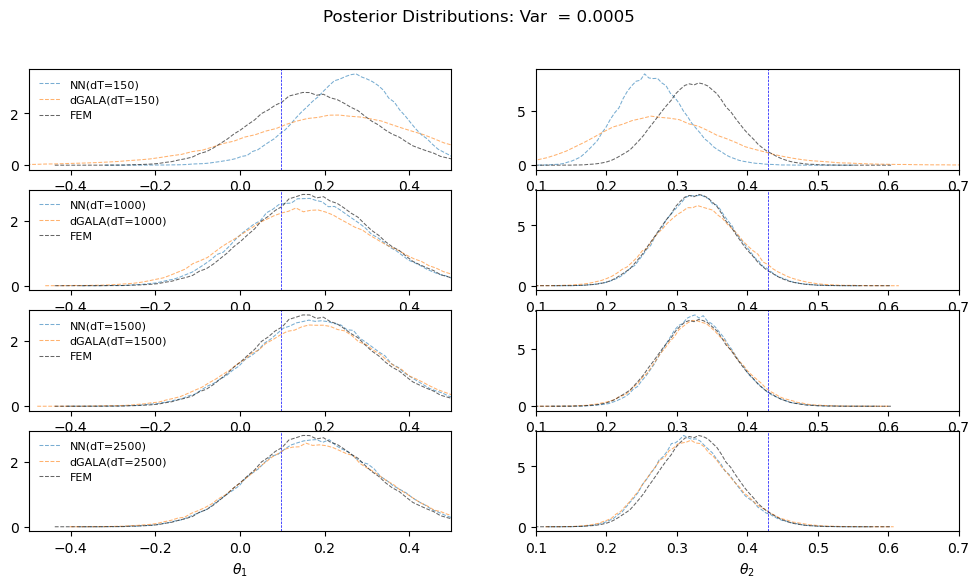

In [25]:
vr = 5e-4

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions: Var  = {vr}")
bins =80

for i,nobs in  enumerate(N):

    sample = np.load(f'./Models/DNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    

    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")



# Modified DNN


In [18]:
#torch.manual_seed(42)

epochs = 5000
lr = 0.001
decay_rate = 0.95   # Decay rate for exponential scheduler
scheduler_step_epochs = 50  # Number of epochs to wait before stepping the scheduler
start_scheduler_epoch = int(epochs * 0.5) 
N = [150,250,500,750,1000,1500,2500]
# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# # # Initialize DNN with Fourier embeddings, weight factorization, and Glorot initialization
# for nobs in N:
#     dataset = dGDataset(size = nobs, param=param_train)

#     x_val,param_val, sol_val = generate_test_data(nobs,param =param_test, vert=30)

#     dataloader = DataLoader(dataset, batch_size=150, shuffle=False)

#     loss = torch.nn.MSELoss(reduction ='mean')

#     model = MDNN()

#     optimizer = torch.optim.Adam(model.parameters(), lr = lr)
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)  # Exponential decay scheduler


#     print(f"Starting Adam Training for model WRF_linear ouput")

#     train_loss, test_loss = [], []

#     for epoch in range(epochs):
#         epoch_train_loss = 0.0  # Accumulate loss over all batches for this epoch
        
#         for data_int, left_bc, right_bc in dataloader:
#             data_int, left_bc, right_bc = data_int.to(device), left_bc.to(device), right_bc.to(device)

#             data_int = Variable(data_int, requires_grad=True)
#             left_bc, right_bc = Variable(left_bc, requires_grad=True), Variable(right_bc, requires_grad=True)
            
#             optimizer.zero_grad()

#             total_loss, loss_pde, loss_lbc, loss_rbc = compute_loss(model, data_int, left_bc, right_bc, loss)

#             total_loss.backward(retain_graph=True)
#             optimizer.step()
            
#             # Accumulate the batch loss into the epoch loss
#             epoch_train_loss += total_loss.item()

#         # Calculate the average loss for the epoch
#         epoch_train_loss /= len(dataloader)
#         train_loss.append(epoch_train_loss)

#         # Compute the test loss at the end of the epoch
#         test_loss_current = compute_mean_error(model,param_val,x_val,sol_val)
#         test_loss.append(test_loss_current)

        
#         # Scheduler step only in the last 25% of epochs, every `scheduler_step_epochs`
#         if epoch >= start_scheduler_epoch and (epoch - start_scheduler_epoch) % scheduler_step_epochs == 0:
#             scheduler.step()

#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Train Loss: {epoch_train_loss:.5e}, Test Loss: {test_loss_current:.5e}')
        

#     np.save(f'./Models/MDNN_train_N{nobs}_batch{150}.npy', np.array(train_loss))
#     np.save(f'./Models/MDNN_test_N{nobs}_batch{150}.npy', np.array(test_loss)) 

#     path = f"./Models/1dElliptic_MDNN_N{nobs}_batch{150}.pt"
#     torch.save(model.state_dict(),path)

In [15]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc
from pyro.infer.mcmc import MCMC
import torch
from FEM_Solver import  FEMSolver


# Define the model using a coarse FEM solver
def model(surrogate_fem_solver,synthetic_data, points,noise_std, device='cpu'):
    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))


    # Use a coarse mesh FEM solver as the surrogate model
    surrogate_fem_solver.theta = theta.detach().numpy()  # Update the parameter vector

    surrogate_fem_solver.uh = None

    surrogate_fem_solver.solve()

    # Get model predictions at the given points
    model_predictions = torch.Tensor(surrogate_fem_solver.eval_at_points(points)).to(device)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(model_predictions, noise_std).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y


def model_dgala(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    surg_sigma = surg_sigma[:, :, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

def model_nn(surrogate,synthetic_data, points, sig,device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([points, theta.repeat(points.size(0), 1)], dim=1)

    surg_mu = surrogate(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(synthetic_data).to(device))

    return y

In [16]:
theta_th=np.array([0.098, 0.430])
solver = FEMSolver(theta_th, vert=320)
solution = solver.solve()

dy = 6
X = np.linspace(0.2,0.8,dy).reshape(-1,1)

#y = solver.eval_at_points(X)


np.random.seed(0)
k = 4
dy = 6
#eta = np.random.normal(0,10**(-k/2),dy)
eta = np.random.normal(0,np.sqrt(1e-4),dy)

y_tia = np.array([4.257174963573532311e-01,6.704236569661589096e-01,9.221336565815004827e-01,1.185151034069622744e+00,
         1.451691910058344304e+00,1.700335624196542383e+00])

y = y_tia + eta

y = y.reshape(-1,1)
y

array([[0.44335802],
       [0.67442523],
       [0.93192104],
       [1.20755997],
       [1.47036749],
       [1.69056285]])

In [ ]:

theta_th=np.array([0.098, 0.430])
vr = 1e-4
st = torch.sqrt(torch.tensor(vr))
hvert = 50

# #obs_points, obs_sol = generate_noisy_obs(10, theta_t=theta_th, mean=0, std=st,vert=200)
# data_parameters = samples_param(5000, nparam=2)
# param_train, param_test = data_parameters[:2500,:],  data_parameters[2500:,:]

# obs_points, obs_sol = torch.tensor(X), torch.tensor(y)

# obs_points, obs_sol = torch.tensor(obs_points, dtype=torch.float32),torch.tensor(obs_sol, dtype=torch.float32)

# st = torch.sqrt(torch.tensor(vr))
# # layers = [3] + 2*[20] + [1]

# for nobs in N:
#     model = MDNN().to(device)
#     model.load_state_dict(torch.load( f"./Models/1dElliptic_MDNN_N{nobs}_batch{150}.pt"))
#     model.eval()

#     kernel = mcmc.RandomWalkKernel(model_nn, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(model,obs_sol,obs_points,st)

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/MDNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

#     #### Deep GaLA
#     data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
#     data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)

#     pde = {"PDE":["de","bc_l","bc_r"], 
#         "data_set":{"de" : Variable(data_int,requires_grad=True),
#         "bc_l":left_bc,
#         "bc_r" :right_bc}}
    
#     llp2 = llaplace2(model)

#     start_time_mh = time.time()  # Start timing
#     llp2.fit(pde=pde, hessian_structure = "full")
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

#     start_time_mh = time.time()  # Start timing
#     llp2.optimize_marginal_likelihood(max_iter=200)
#     end_time_mh = time.time()  # End timing
#     print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")
    
#     kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

#     mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

#     mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
#                      torch.tensor(obs_points).float().to(device),
#                      torch.sqrt(torch.tensor(vr).float().to(device)))

#     # Get the results (posterior samples)
#     samples = mcmc_sampler.get_samples()
#     samples = samples["theta"].numpy()

#     np.save(f'./Models/dGaLA2_MDNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy', samples)
#     del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 1005000/1005000 [07:28, 2242.54it/s, step size=1.19e-01, acc. prob=0.232]


Total time for fitting: 0.005243853727976481
Iteration 100, Error: 0.00975, neg_marglik: 49.10341
Iteration 200, Error: 0.00866, neg_marglik: -179.36710
Maximum iterations (200)reached, sigma : 0.13852646946907043, prior: 6.41798210144043.
Total time for optimizing: 0.017753207683563234


Sample: 100%|██████████| 1005000/1005000 [07:43, 2165.99it/s, step size=1.19e-01, acc. prob=0.226]


Total time for fitting: 0.019602620601654054
Iteration 100, Error: 0.00971, neg_marglik: 40.51773
Iteration 200, Error: 0.00863, neg_marglik: -441.68585
Maximum iterations (200)reached, sigma : 0.13705626130104065, prior: 6.254026412963867.
Total time for optimizing: 0.012525423367818197


Sample: 100%|██████████| 1005000/1005000 [07:38, 2193.83it/s, step size=1.15e-01, acc. prob=0.236]


Total time for fitting: 0.03338874975840251
Iteration 100, Error: 0.00966, neg_marglik: 28.09209
Iteration 200, Error: 0.00847, neg_marglik: -698.78186
Maximum iterations (200)reached, sigma : 0.13726752996444702, prior: 6.121282577514648.
Total time for optimizing: 0.011039698123931884


Sample: 100%|██████████| 1005000/1005000 [17:47, 941.16it/s, step size=1.27e-01, acc. prob=0.238]


(Text(0.5, 0, '$\\theta_{1}$'), Text(0.5, 0, '$\\theta_{2}$'))

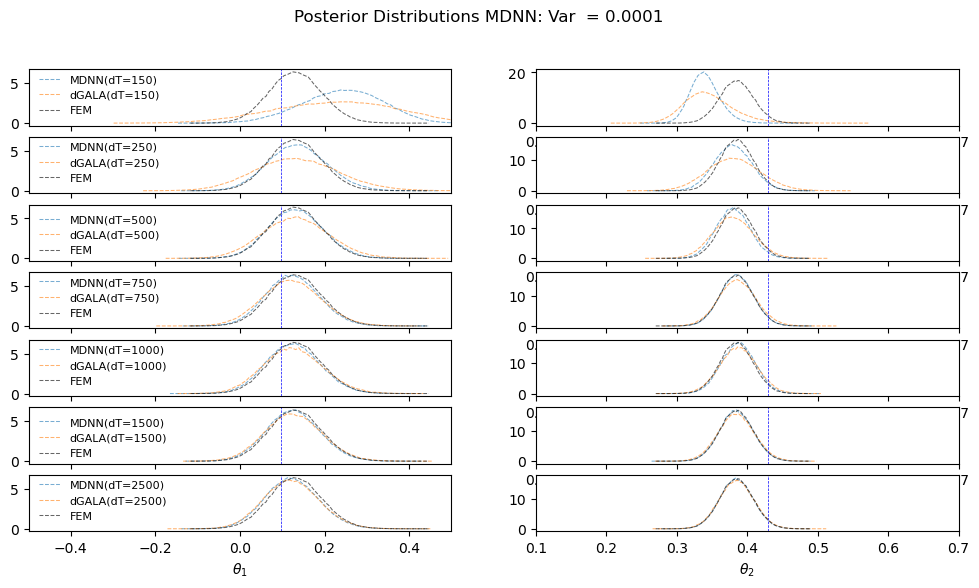

In [19]:
bins =80
vr = 1e-4
hvert = 50
theta_th=np.array([0.098, 0.430])

fig, axs = plt.subplots(len(N), 2, figsize=(12, 6))
fig.suptitle(f"Posterior Distributions MDNN: Var  = {vr}")

for i,nobs in  enumerate(N):

    sample = np.load(f'./Models/MDNN_var{vr}_hl{2}_w{20}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"MDNN(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"MDNN(dT={nobs})")

    sample = np.load(f'./Models/dGaLA2_MDNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"dGALA(dT={nobs})")
    
    sample = np.load(f'./Models/FEM_pyro_h{hvert}_var{vr}_obs{6}_tiaming.npy')

    bin_centers, counts = histogram_(sample[:, 0],bins=bins)
    axs[i,0].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    bin_centers, counts = histogram_(sample[:, 1],bins=bins)
    axs[i,1].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"FEM",color = "black")
    
    axs[i,0].legend(frameon = False, fontsize =8)
    axs[i,0].axvline(x = theta_th[0], color = 'b',linestyle="--", linewidth=0.5)
    axs[i,1].axvline(x = theta_th[1], color = 'b',linestyle="--", linewidth=0.5)

    axs[i,1].set_xlim((0.1,0.7)),axs[i,0].set_xlim((-0.5,0.5))

axs[-1,0].set_xlabel("$\\theta_{1}$"),axs[-1,1].set_xlabel("$\\theta_{2}$")

